In [1]:
# Data manipulation
import pandas as pd
import numpy as np
# Evaluation of the model
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.size'] = 18
%matplotlib inline
MAX_EVALS = 20
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer
import json
import shlex
import subprocess
import logging
from pprint import pprint
import re
import os


In [2]:
file_suffix = "S3D-IO-100-200-200-4-4-8-1" + str(MAX_EVALS)
def runthebenchmark(hyperparameters):
    os.chdir('/home/dsinghvi/project/progress/active/../')
    storeinfile(hyperparameters)
    out=subprocess.Popen(["python3","read_config_general.py","-n 16","-c100 200 200 4 4 8 1"], shell=False, stdout=subprocess.PIPE)
    logging.basicConfig(level=logging.DEBUG)
    output=out.stdout.read().decode('utf-8')
    print("output"+output)
    if len(output.split(" ")) > 5:
        values = output.split(" ")
        value = float(float(values[6])*1024)/float(values[5]) + float(float(values[3])*1024)/float(values[2])
        value = float(value)
        print(value)
        return float((value/100)**3),output
    return 0,0;

In [3]:
def storeinfile(hyperparameters):
    data={"mpi": {"romio_ds_read": "enable", "romio_ds_write": "disable"}, "lfs": {"setstripe": {"size": "16777216", "count": 4}}}
    data["lfs"]["setstripe"]["size"] = int(hyperparameters["setstripe-size"])
    data["lfs"]["setstripe"]["count"] = int(hyperparameters["setstripe-count"])

    data["mpi"]["romio_ds_read"] = hyperparameters["romio_ds_read"]
    data["mpi"]["romio_ds_write"] = hyperparameters["romio_ds_write"]
    data["mpi"]["romio_cb_read"] = hyperparameters["romio_cb_read"]
    data["mpi"]["romio_cb_write"] = hyperparameters["romio_cb_write"]
    data["mpi"]["cb_buffer_size"] = str(int(hyperparameters["cb_buffer_size"]))
    with open("confex.json","w") as fp:
        json.dump(data,fp)
    print(data)


In [4]:
def objective(hyperparameters):
    global ITERATION
    ITERATION += 1
    start = timer()
    result=0
    while(result == 0):
        print("rerun")
        result,output = runthebenchmark(hyperparameters)
        print(result)
    run_time = timer() - start
    print({'loss': result, 'hyperparameters': hyperparameters, 'iteration': ITERATION, 'iteration_time': run_time, 'status': STATUS_OK})
    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([float(result), hyperparameters, ITERATION, run_time, output])
    return {'loss': float(result), 'hyperparameters': hyperparameters, 'iteration': ITERATION, 'iteration_time': run_time, 'status': STATUS_OK}


In [5]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

space = {
    'romio_ds_read' : hp.choice('romio_ds_read',['enable','disable']),
    'romio_ds_write' : hp.choice('romio_ds_write',['enable','disable']),
    'romio_cb_read' : hp.choice('romio_cb_read',['enable','disable']),
    'romio_cb_write' : hp.choice('romio_cb_write',['enable','disable']),
    'cb_buffer_size' : 1048576*hp.quniform('cb_buffer_size',1,512,1),
    'setstripe-size' : 65536*(hp.quniform('setstripe-size',0,512,1)),
    'setstripe-count' : hp.qloguniform('setstripe-count',0,5,1)
    
}

In [6]:
x = sample(space)
params = x
print(x)

cb_buffer_size_dist = []
for _ in range(1000):
    cb_buffer_size_dist.append(sample(space)['cb_buffer_size'])
    
setstripe_size_dist = []
for _ in range(1000):
    setstripe_size_dist.append(sample(space)['setstripe-size'])
    
setstripe_count_dist = []
for _ in range(1000):
    setstripe_count_dist.append(sample(space)['setstripe-count']) 
    
romio_ds_read_dist = []
for _ in range(20):
    romio_ds_read_dist.append(sample(space)['romio_ds_read'])
    
romio_ds_write_dist = []
for _ in range(20):
    romio_ds_write_dist.append(sample(space)['romio_ds_write'])
    
romio_cb_read_dist = []
for _ in range(20):
    romio_cb_read_dist.append(sample(space)['romio_cb_read']) 
    
romio_cb_write_dist = []
for _ in range(20):
    romio_cb_write_dist.append(sample(space)['romio_cb_write']) 
    

{'cb_buffer_size': 390070272.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 3.0, 'setstripe-size': 30408704.0}


In [7]:
# File to save first results
print(os.getcwd())
out_file = '/home/dsinghvi/project/progress/active/result/gbm_trials-'+file_suffix+'.csv'

of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)
writer.writerow(['loss', 'params', 'iteration', 'train_time', 'output'])
of_connection.close()

/home/dsinghvi/project/progress/active


In [8]:
from hyperopt import tpe

# Create the algorithm
tpe_algorithm = tpe.suggest


from hyperopt import Trials

# Record results
bayes_trials = Trials()

from hyperopt import fmin


ITERATION = 20

best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = bayes_trials, max_evals = MAX_EVALS)

rerun                                               
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '264241152'}, 'lfs': {'setstripe': {'size': 8650752, 'count': 5}}}
outputS3D-IO 100-100-200-4-4-8-1 627.25 0.24 0.39 476.51 0.72 1.54 0.07 0.03 8650752 5 disable enable disable enable 264241152 

1.9390552955865776                                  
7.2907227247204305e-06                              
{'loss': 7.2907227247204305e-06, 'hyperparameters': {'cb_buffer_size': 264241152.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 5.0, 'setstripe-size': 8650752.0}, 'iteration': 21, 'iteration_time': 7.070165517739952, 'status': 'ok'}
  5%|▌         | 1/20 [00:07<02:14,  7.09s/it, best loss: 7.2907227247204305e-06]

INFO:hyperopt.tpe:tpe_transform took 0.011178 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.000007


rerun                                                                            
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '179306496'}, 'lfs': {'setstripe': {'size': 32899072, 'count': 126}}}
outputS3D-IO 100-100-200-4-4-8-1 1865.32 0.24 0.13 612.56 0.72 1.20 0.09 0.03 32899072 126 disable enable disable enable 179306496 

1.3353567375141828                                                               
2.3811782442769662e-06                                                           
{'loss': 2.3811782442769662e-06, 'hyperparameters': {'cb_buffer_size': 179306496.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 126.0, 'setstripe-size': 32899072.0}, 'iteration': 22, 'iteration_time': 6.19347754586488, 'status': 'ok'}
 10%|█         | 2/20 [00:13<02:02,  6.83s/it, best loss: 2.3811782442769662e-06]

INFO:hyperopt.tpe:tpe_transform took 0.009460 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.000002


rerun                                                                            
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '451936256'}, 'lfs': {'setstripe': {'size': 11337728, 'count': 26}}}
outputS3D-IO 100-100-200-4-4-8-1 1423.19 0.24 0.17 401.06 0.72 1.83 0.09 0.02 11337728 26 enable enable enable enable 451936256 

2.011010924619906                                                                
8.132859873174364e-06                                                            
{'loss': 8.132859873174364e-06, 'hyperparameters': {'cb_buffer_size': 451936256.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 26.0, 'setstripe-size': 11337728.0}, 'iteration': 23, 'iteration_time': 6.973321207799017, 'status': 'ok'}
 15%|█▌        | 3/20 [00:20<01:56,  6.88s/it, best loss: 2.3811782442769662e-06]

INFO:hyperopt.tpe:tpe_transform took 0.009982 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.000002


rerun                                                                            
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '440401920'}, 'lfs': {'setstripe': {'size': 6488064, 'count': 4}}}
outputS3D-IO 100-100-200-4-4-8-1 933.42 0.24 0.26 293.96 0.72 2.49 0.09 0.02 6488064 4 disable disable enable enable 440401920 

2.77138617701029                                                                 
2.1285856962964794e-05                                                           
{'loss': 2.1285856962964794e-05, 'hyperparameters': {'cb_buffer_size': 440401920.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 4.0, 'setstripe-size': 6488064.0}, 'iteration': 24, 'iteration_time': 7.571077900007367, 'status': 'ok'}
 20%|██        | 4/20 [00:27<01:53,  7.10s/it, best loss: 2.3811782442769662e-06]

INFO:hyperopt.tpe:tpe_transform took 0.015693 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.000002


rerun                                                                            
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '20971520'}, 'lfs': {'setstripe': {'size': 28573696, 'count': 2}}}
outputS3D-IO 100-100-200-4-4-8-1 1715.01 0.24 0.14 338.67 0.72 2.16 0.08 0.02 28573696 2 disable enable disable disable 20971520 

2.320285902963638                                                                
1.2491785101271737e-05                                                           
{'loss': 1.2491785101271737e-05, 'hyperparameters': {'cb_buffer_size': 20971520.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 2.0, 'setstripe-size': 28573696.0}, 'iteration': 25, 'iteration_time': 7.355310482904315, 'status': 'ok'}
 25%|██▌       | 5/20 [00:35<01:47,  7.19s/it, best loss: 2.3811782442769662e-06]

INFO:hyperopt.tpe:tpe_transform took 0.009613 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.000002


rerun                                                                            
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '226492416'}, 'lfs': {'setstripe': {'size': 1900544, 'count': 1}}}
outputS3D-IO 100-100-200-4-4-8-1 1660.85 0.24 0.15 215.83 0.72 3.39 0.10 0.02 1900544 1 disable enable enable enable 226492416 

3.5639942928225334                                                               
4.5270052665000065e-05                                                           
{'loss': 4.5270052665000065e-05, 'hyperparameters': {'cb_buffer_size': 226492416.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 1.0, 'setstripe-size': 1900544.0}, 'iteration': 26, 'iteration_time': 8.383194494061172, 'status': 'ok'}
 30%|███       | 6/20 [00:43<01:45,  7.55s/it, best loss: 2.3811782442769662e-06]

INFO:hyperopt.tpe:tpe_transform took 0.012531 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.000002


rerun                                                                            
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '299892736'}, 'lfs': {'setstripe': {'size': 28246016, 'count': 4}}}
outputS3D-IO 100-100-200-4-4-8-1 1198.89 0.24 0.20 450.78 0.72 1.62 0.08 0.02 28246016 4 enable enable enable disable 299892736 

1.8405546360251461                                                               
6.235139025419408e-06                                                            
{'loss': 6.235139025419408e-06, 'hyperparameters': {'cb_buffer_size': 299892736.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 4.0, 'setstripe-size': 28246016.0}, 'iteration': 27, 'iteration_time': 6.692958612926304, 'status': 'ok'}
 35%|███▌      | 7/20 [00:50<01:34,  7.31s/it, best loss: 2.3811782442769662e-06]

INFO:hyperopt.tpe:tpe_transform took 0.009835 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.000002


rerun                                                                            
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '523239424'}, 'lfs': {'setstripe': {'size': 17432576, 'count': 34}}}
outputS3D-IO 100-100-200-4-4-8-1 1240.85 0.24 0.20 534.32 0.72 1.37 0.10 0.02 17432576 34 disable disable enable enable 523239424 

1.5779050654986746                                                               
3.928643410016205e-06                                                            
{'loss': 3.928643410016205e-06, 'hyperparameters': {'cb_buffer_size': 523239424.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 34.0, 'setstripe-size': 17432576.0}, 'iteration': 28, 'iteration_time': 6.430069437250495, 'status': 'ok'}
 40%|████      | 8/20 [00:56<01:24,  7.05s/it, best loss: 2.3811782442769662e-06]

INFO:hyperopt.tpe:tpe_transform took 0.009749 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.000002


rerun                                                                            
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '409993216'}, 'lfs': {'setstripe': {'size': 21692416, 'count': 1}}}
outputS3D-IO 100-100-200-4-4-8-1 1229.45 0.24 0.20 317.33 0.72 2.31 0.10 0.02 21692416 1 enable enable enable disable 409993216 

2.523280011512032                                                                
1.606557752468087e-05                                                            
{'loss': 1.606557752468087e-05, 'hyperparameters': {'cb_buffer_size': 409993216.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 1.0, 'setstripe-size': 21692416.0}, 'iteration': 29, 'iteration_time': 7.457718097604811, 'status': 'ok'}
 45%|████▌     | 9/20 [01:04<01:19,  7.18s/it, best loss: 2.3811782442769662e-06]

INFO:hyperopt.tpe:tpe_transform took 0.009693 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.000002


rerun                                                                            
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '211812352'}, 'lfs': {'setstripe': {'size': 22347776, 'count': 12}}}
outputS3D-IO 100-100-200-4-4-8-1 1588.21 0.24 0.15 460.75 0.72 1.59 0.10 0.02 22347776 12 enable disable disable disable 211812352 

1.7549138721105786                                                               
5.404648085897355e-06                                                            
{'loss': 5.404648085897355e-06, 'hyperparameters': {'cb_buffer_size': 211812352.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 12.0, 'setstripe-size': 22347776.0}, 'iteration': 30, 'iteration_time': 6.418726064264774, 'status': 'ok'}
 50%|█████     | 10/20 [01:10<01:09,  6.96s/it, best loss: 2.3811782442769662e-06]

INFO:hyperopt.tpe:tpe_transform took 0.009856 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 0.000002


rerun                                                                             
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '180355072'}, 'lfs': {'setstripe': {'size': 22020096, 'count': 4}}}
outputS3D-IO 100-100-200-4-4-8-1 1230.12 0.24 0.20 451.83 0.72 1.62 0.07 0.02 22020096 4 enable enable enable disable 180355072 

1.8315495458779145                                                                
6.1440680082896744e-06                                                            
{'loss': 6.1440680082896744e-06, 'hyperparameters': {'cb_buffer_size': 180355072.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 4.0, 'setstripe-size': 22020096.0}, 'iteration': 31, 'iteration_time': 6.76702453289181, 'status': 'ok'}
 55%|█████▌    | 11/20 [01:17<01:02,  6.91s/it, best loss: 2.3811782442769662e-06]

INFO:hyperopt.tpe:tpe_transform took 0.009933 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 0.000002


rerun                                                                             
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '282066944'}, 'lfs': {'setstripe': {'size': 18284544, 'count': 37}}}
outputS3D-IO 100-100-200-4-4-8-1 722.10 0.24 0.34 333.83 0.72 2.19 0.10 0.01 18284544 37 enable enable enable disable 282066944 

2.548889934637191                                                                 
1.6559729825242224e-05                                                            
{'loss': 1.6559729825242224e-05, 'hyperparameters': {'cb_buffer_size': 282066944.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 37.0, 'setstripe-size': 18284544.0}, 'iteration': 32, 'iteration_time': 7.349395914934576, 'status': 'ok'}
 60%|██████    | 12/20 [01:25<00:56,  7.05s/it, best loss: 2.3811782442769662e-06]

INFO:hyperopt.tpe:tpe_transform took 0.009610 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 0.000002


rerun                                                                             
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '341835776'}, 'lfs': {'setstripe': {'size': 5898240, 'count': 2}}}
outputS3D-IO 100-100-200-4-4-8-1 1497.73 0.24 0.16 235.06 0.72 3.12 0.09 0.02 5898240 2 enable disable disable enable 341835776 

3.3006491983984416                                                                
3.595821348439044e-05                                                             
{'loss': 3.595821348439044e-05, 'hyperparameters': {'cb_buffer_size': 341835776.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 2.0, 'setstripe-size': 5898240.0}, 'iteration': 33, 'iteration_time': 8.601054636761546, 'status': 'ok'}
 65%|██████▌   | 13/20 [01:33<00:52,  7.53s/it, best loss: 2.3811782442769662e-06]

INFO:hyperopt.tpe:tpe_transform took 0.018112 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 0.000002


rerun                                                                             
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '130023424'}, 'lfs': {'setstripe': {'size': 17694720, 'count': 4}}}
outputS3D-IO 100-100-200-4-4-8-1 1599.54 0.24 0.15 401.51 0.72 1.82 0.08 0.02 17694720 4 disable enable disable disable 130023424 

1.9899122606675723                                                                
7.879556676366479e-06                                                             
{'loss': 7.879556676366479e-06, 'hyperparameters': {'cb_buffer_size': 130023424.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 4.0, 'setstripe-size': 17694720.0}, 'iteration': 34, 'iteration_time': 6.727173686958849, 'status': 'ok'}
 70%|███████   | 14/20 [01:40<00:43,  7.30s/it, best loss: 2.3811782442769662e-06]

INFO:hyperopt.tpe:tpe_transform took 0.009868 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 0.000002


rerun                                                                             
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '461373440'}, 'lfs': {'setstripe': {'size': 6291456, 'count': 6}}}
outputS3D-IO 100-100-200-4-4-8-1 659.93 0.24 0.37 477.43 0.72 1.53 0.07 0.02 6291456 6 enable enable enable disable 461373440 

1.9166714033596783                                                                
7.041140165396204e-06                                                             
{'loss': 7.041140165396204e-06, 'hyperparameters': {'cb_buffer_size': 461373440.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 6.0, 'setstripe-size': 6291456.0}, 'iteration': 35, 'iteration_time': 6.611450774595141, 'status': 'ok'}
 75%|███████▌  | 15/20 [01:47<00:35,  7.10s/it, best loss: 2.3811782442769662e-06]

INFO:hyperopt.tpe:tpe_transform took 0.009663 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 0.000002


rerun                                                                             
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '258998272'}, 'lfs': {'setstripe': {'size': 33095680, 'count': 4}}}
outputS3D-IO 100-100-200-4-4-8-1 1293.69 0.24 0.19 372.29 0.72 1.97 0.07 0.02 33095680 4 enable enable enable disable 258998272 

2.1703598605914585                                                                
1.0223397485706647e-05                                                            
{'loss': 1.0223397485706647e-05, 'hyperparameters': {'cb_buffer_size': 258998272.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 4.0, 'setstripe-size': 33095680.0}, 'iteration': 36, 'iteration_time': 6.995218396186829, 'status': 'ok'}
 80%|████████  | 16/20 [01:54<00:28,  7.08s/it, best loss: 2.3811782442769662e-06]

INFO:hyperopt.tpe:tpe_transform took 0.009759 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 0.000002


rerun                                                                             
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '524288000'}, 'lfs': {'setstripe': {'size': 6422528, 'count': 18}}}
outputS3D-IO 100-100-200-4-4-8-1 648.56 0.24 0.38 424.70 0.72 1.72 0.08 0.03 6422528 18 disable enable disable enable 524288000 

2.11493367102687                                                                  
9.459980789652253e-06                                                             
{'loss': 9.459980789652253e-06, 'hyperparameters': {'cb_buffer_size': 524288000.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 18.0, 'setstripe-size': 6422528.0}, 'iteration': 37, 'iteration_time': 8.917530499398708, 'status': 'ok'}
 85%|████████▌ | 17/20 [02:03<00:22,  7.64s/it, best loss: 2.3811782442769662e-06]

INFO:hyperopt.tpe:tpe_transform took 0.009899 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 0.000002


rerun                                                                             
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '462422016'}, 'lfs': {'setstripe': {'size': 589824, 'count': 24}}}
outputS3D-IO 100-100-200-4-4-8-1 1874.61 0.24 0.13 551.66 0.72 1.33 0.09 0.01 589824 24 disable enable disable disable 462422016 

1.4675746339090903                                                                
3.160826006362461e-06                                                             
{'loss': 3.160826006362461e-06, 'hyperparameters': {'cb_buffer_size': 462422016.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 24.0, 'setstripe-size': 589824.0}, 'iteration': 38, 'iteration_time': 6.2905908692628145, 'status': 'ok'}
 90%|█████████ | 18/20 [02:09<00:14,  7.24s/it, best loss: 2.3811782442769662e-06]

INFO:hyperopt.tpe:tpe_transform took 0.009627 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 0.000002


rerun                                                                             
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '307232768'}, 'lfs': {'setstripe': {'size': 8650752, 'count': 109}}}
outputS3D-IO 100-100-200-4-4-8-1 1518.97 0.24 0.16 303.33 0.72 2.41 0.10 0.01 8650752 109 disable enable enable disable 307232768 

2.592413963851001                                                                 
1.7422603624304248e-05                                                            
{'loss': 1.7422603624304248e-05, 'hyperparameters': {'cb_buffer_size': 307232768.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 109.0, 'setstripe-size': 8650752.0}, 'iteration': 39, 'iteration_time': 7.452704122290015, 'status': 'ok'}
 95%|█████████▌| 19/20 [02:16<00:07,  7.31s/it, best loss: 2.3811782442769662e-06]

INFO:hyperopt.tpe:tpe_transform took 0.009989 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 0.000002


rerun                                                                             
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '155189248'}, 'lfs': {'setstripe': {'size': 20119552, 'count': 7}}}
outputS3D-IO 100-100-200-4-4-8-1 1621.01 0.24 0.15 421.86 0.72 1.74 0.08 0.03 20119552 7 enable enable enable disable 155189248 

1.899297988642912                                                                 
6.851400025730462e-06                                                             
{'loss': 6.851400025730462e-06, 'hyperparameters': {'cb_buffer_size': 155189248.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 7.0, 'setstripe-size': 20119552.0}, 'iteration': 40, 'iteration_time': 6.772280840203166, 'status': 'ok'}
100%|██████████| 20/20 [02:23<00:00,  7.16s/it, best loss: 2.3811782442769662e-06]


In [9]:
print(best)
d=  best
#print(bayes_trials.results)
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
#bayes_trials_results[:1]

{'cb_buffer_size': 171.0, 'romio_cb_read': 1, 'romio_cb_write': 0, 'romio_ds_read': 1, 'romio_ds_write': 0, 'setstripe-count': 126.0, 'setstripe-size': 502.0}


In [10]:
results = pd.read_csv(out_file)

# Sort with best scores on top and reset index for slicing
results.sort_values('train_time', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()


,loss,params,iteration,train_time,output
0,0.000002,"{'cb_buffer_size': 179306496.0, 'romio_cb_read...",22,6.193478,S3D-IO 100-100-200-4-4-8-1 1865.32 0.24 0.13 6...
1,0.000003,"{'cb_buffer_size': 462422016.0, 'romio_cb_read...",38,6.290591,S3D-IO 100-100-200-4-4-8-1 1874.61 0.24 0.13 5...
2,0.000005,"{'cb_buffer_size': 211812352.0, 'romio_cb_read...",30,6.418726,S3D-IO 100-100-200-4-4-8-1 1588.21 0.24 0.15 4...
3,0.000004,"{'cb_buffer_size': 523239424.0, 'romio_cb_read...",28,6.430069,S3D-IO 100-100-200-4-4-8-1 1240.85 0.24 0.20 5...
4,0.000007,"{'cb_buffer_size': 461373440.0, 'romio_cb_read...",35,6.611451,S3D-IO 100-100-200-4-4-8-1 659.93 0.24 0.37 47...


In [11]:
import ast

# Convert from a string to a dictionary
ast.literal_eval(results.loc[0, 'params'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()
print(best_bayes_params)
log = open('best.txt','a')
print(results.loc[0,'output'])
print(results.loc[0,'output'],file=log)
log.close()

{'cb_buffer_size': 179306496.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 126.0, 'setstripe-size': 32899072.0}
S3D-IO 100-100-200-4-4-8-1 1865.32 0.24 0.13 612.56 0.72 1.20 0.09 0.03 32899072 126 disable enable disable enable 179306496 



In [12]:
bayes_params = pd.DataFrame(columns = list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index = list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
bayes_params['train_time'] = results['train_time']    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']
bayes_params['output']=results['output']

bayes_params.head()

,cb_buffer_size,romio_cb_read,romio_cb_write,romio_ds_read,romio_ds_write,setstripe-count,setstripe-size,train_time,loss,iteration,output
0,1.79306e+08,disable,enable,disable,enable,126,3.28991e+07,6.193478,0.000002,22,S3D-IO 100-100-200-4-4-8-1 1865.32 0.24 0.13 6...
1,4.62422e+08,disable,disable,disable,enable,24,589824,6.290591,0.000003,38,S3D-IO 100-100-200-4-4-8-1 1874.61 0.24 0.13 5...
2,2.11812e+08,disable,disable,enable,disable,12,2.23478e+07,6.418726,0.000005,30,S3D-IO 100-100-200-4-4-8-1 1588.21 0.24 0.15 4...
3,5.23239e+08,enable,enable,disable,disable,34,1.74326e+07,6.430069,0.000004,28,S3D-IO 100-100-200-4-4-8-1 1240.85 0.24 0.20 5...
4,4.61373e+08,enable,disable,enable,enable,6,6.29146e+06,6.611451,0.000007,35,S3D-IO 100-100-200-4-4-8-1 659.93 0.24 0.37 47...


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=18.0 to DejaVu Sans ('/home/dsinghvi/project/progress/env/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=21.599999999999998 to DejaVu Sans ('/home/dsinghvi/project/progress/env/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


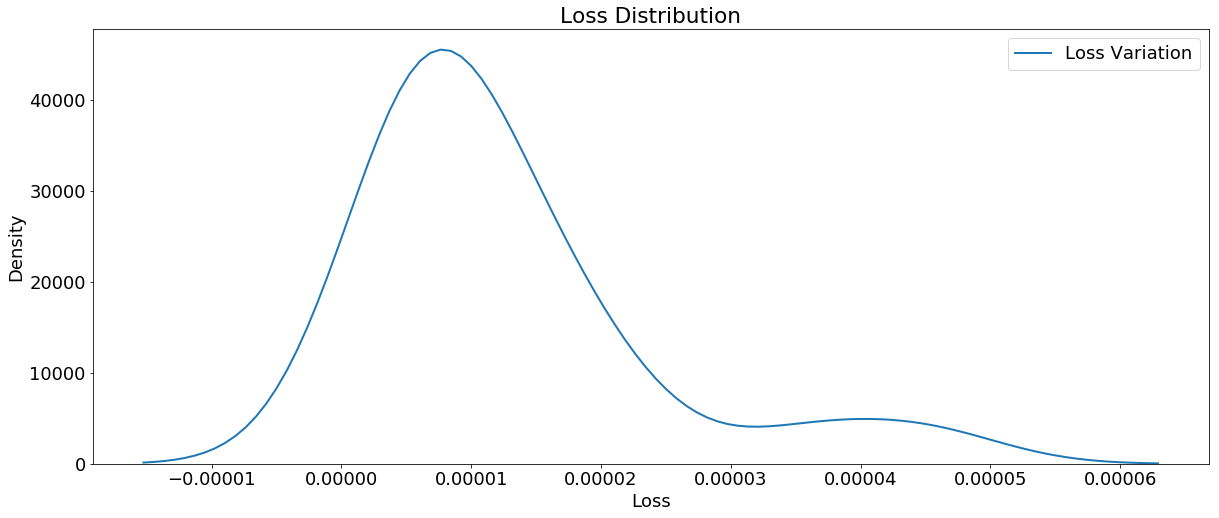

In [13]:
os.chdir('./plots')
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

# Density plots of the learning rate distributions 
sns.kdeplot(bayes_params['loss'], label = 'Loss Variation', linewidth = 2)
plt.legend()
plt.xlabel('Loss'); plt.ylabel('Density'); plt.title('Loss Distribution');
plt.savefig(file_suffix+'_loss.png')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


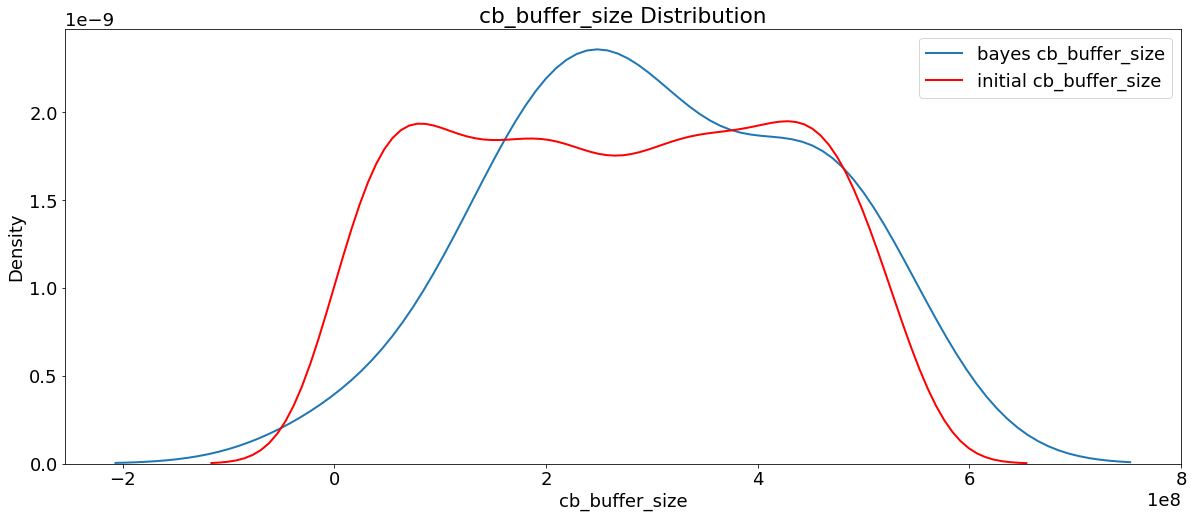

In [14]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18


sns.kdeplot(bayes_params['cb_buffer_size'], label = 'bayes cb_buffer_size', linewidth = 2)
sns.kdeplot(cb_buffer_size_dist,color="red",linewidth=2, label = 'initial cb_buffer_size')

plt.legend()
plt.xlabel('cb_buffer_size'); plt.ylabel('Density'); plt.title('cb_buffer_size Distribution');
plt.savefig(file_suffix+'_cb_buffer_size.png')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


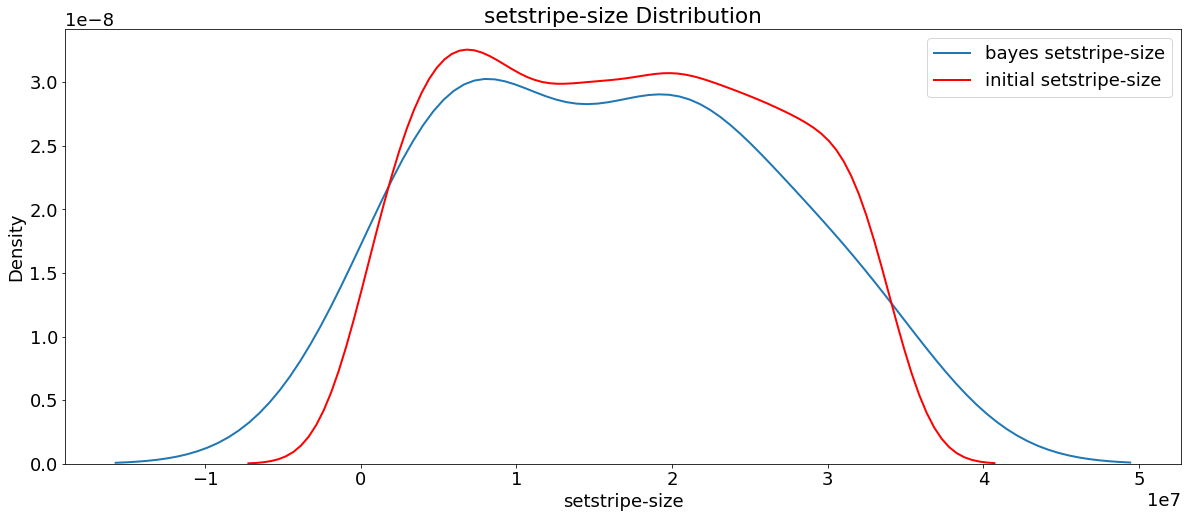

In [15]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

sns.kdeplot(bayes_params['setstripe-size'], label = 'bayes setstripe-size', linewidth = 2)
sns.kdeplot(setstripe_size_dist,color="red",linewidth=2, label = 'initial setstripe-size')

plt.legend()
plt.xlabel('setstripe-size'); plt.ylabel('Density'); plt.title('setstripe-size Distribution');
plt.savefig(file_suffix+'_setstripe-size.png')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


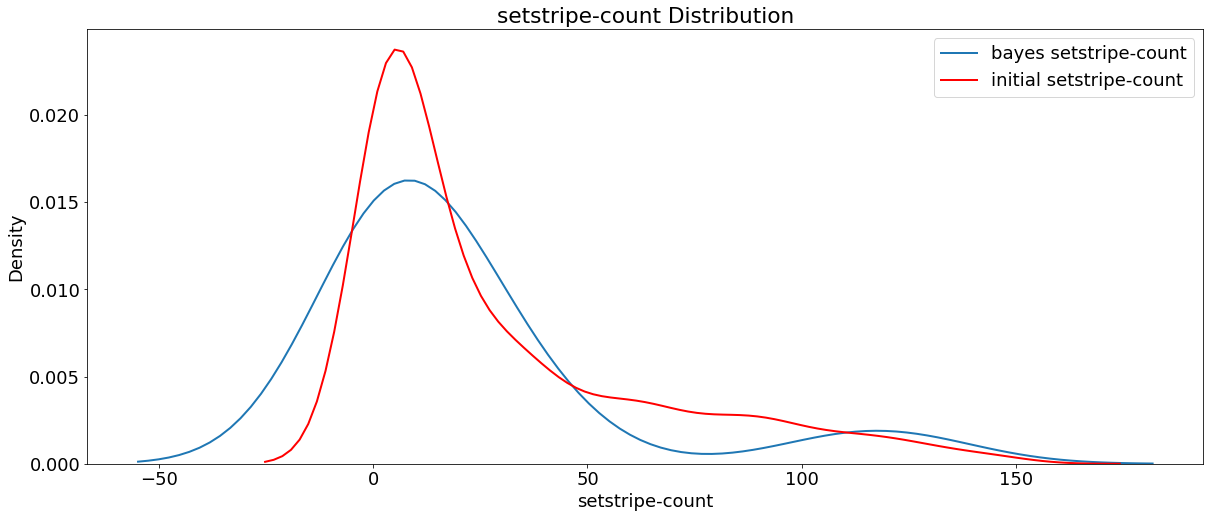

In [16]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

sns.kdeplot(bayes_params['setstripe-count'], label = 'bayes setstripe-count', linewidth = 2)
sns.kdeplot(setstripe_count_dist,color="red",linewidth=2, label = 'initial setstripe-count')

plt.legend()
plt.xlabel('setstripe-count'); plt.ylabel('Density'); plt.title('setstripe-count Distribution');
plt.savefig(file_suffix+'_setstripe-count.png')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


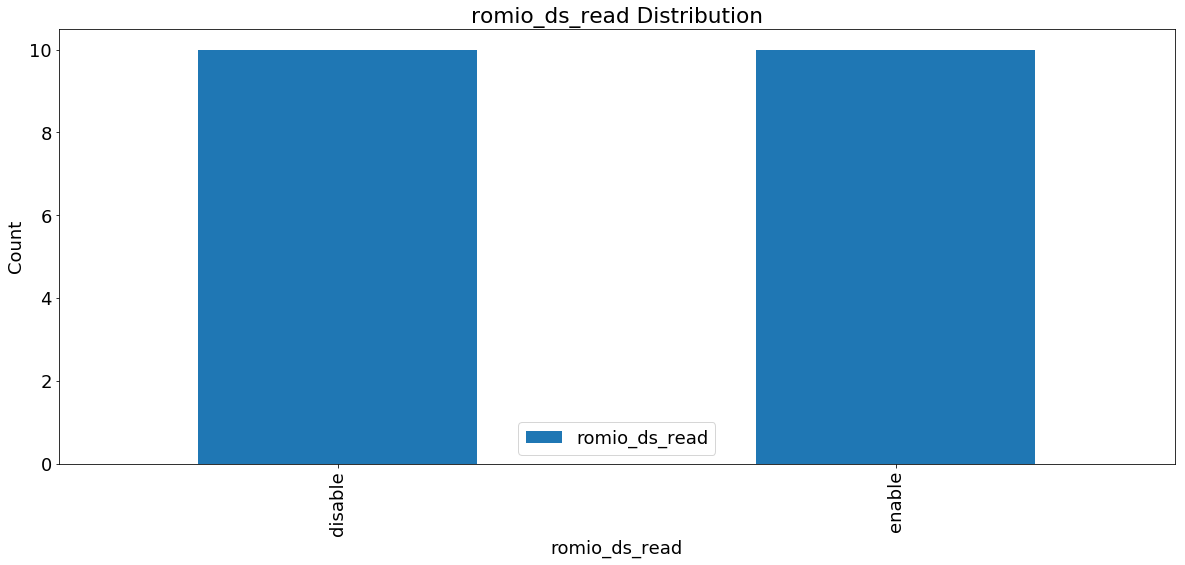

In [17]:
plt.figure(figsize = (20, 8))
from scipy.stats import itemfreq
plt.rcParams['font.size'] = 18
bayes_params['romio_ds_read'].value_counts().plot.bar()#plt.hist(romio_ds_read_dist,color="red",linewidth=2, label = 'initial romio_ds_read')

plt.legend()
plt.xlabel('romio_ds_read'); plt.ylabel('Count'); plt.title('romio_ds_read Distribution');
plt.savefig(file_suffix+'_romio_ds_read.png')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


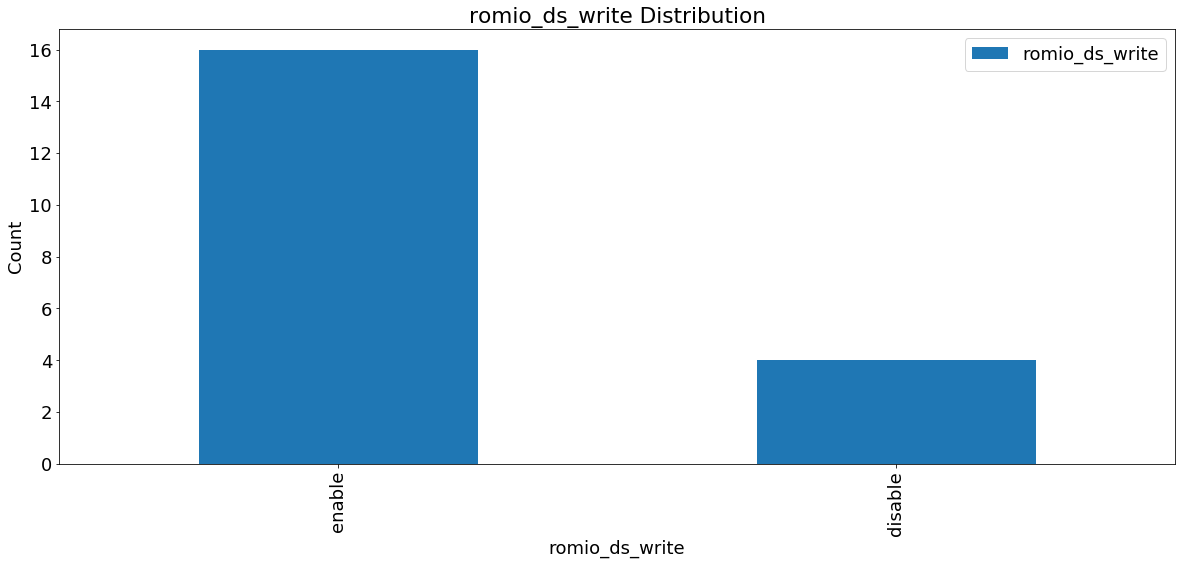

In [18]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

#plt.hist(bayes_params['romio_ds_write'], label = 'bayes romio_ds_write', linewidth = 2)
#plt.hist(romio_ds_write_dist,color="red",linewidth=2, label = 'initial romio_ds_write')
bayes_params['romio_ds_write'].value_counts().plot.bar()
plt.legend()
plt.xlabel('romio_ds_write'); plt.ylabel('Count'); plt.title('romio_ds_write Distribution');
plt.savefig(file_suffix+'_romio_ds_write.png')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


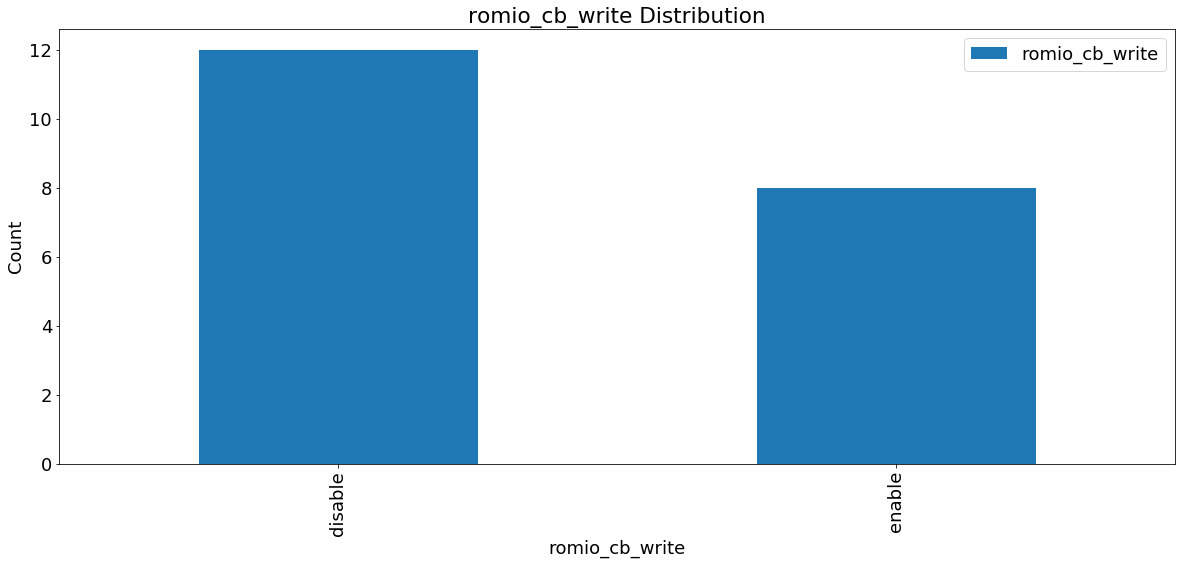

In [19]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

bayes_params['romio_cb_write'].value_counts().plot.bar()#plt.hist(romio_ds_write_dist,color="red",linewidth=2, label = 'initial romio_cb_write')

plt.legend()
plt.xlabel('romio_cb_write'); plt.ylabel('Count'); plt.title('romio_cb_write Distribution');
plt.savefig(file_suffix+'_romio_cb_write.png')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


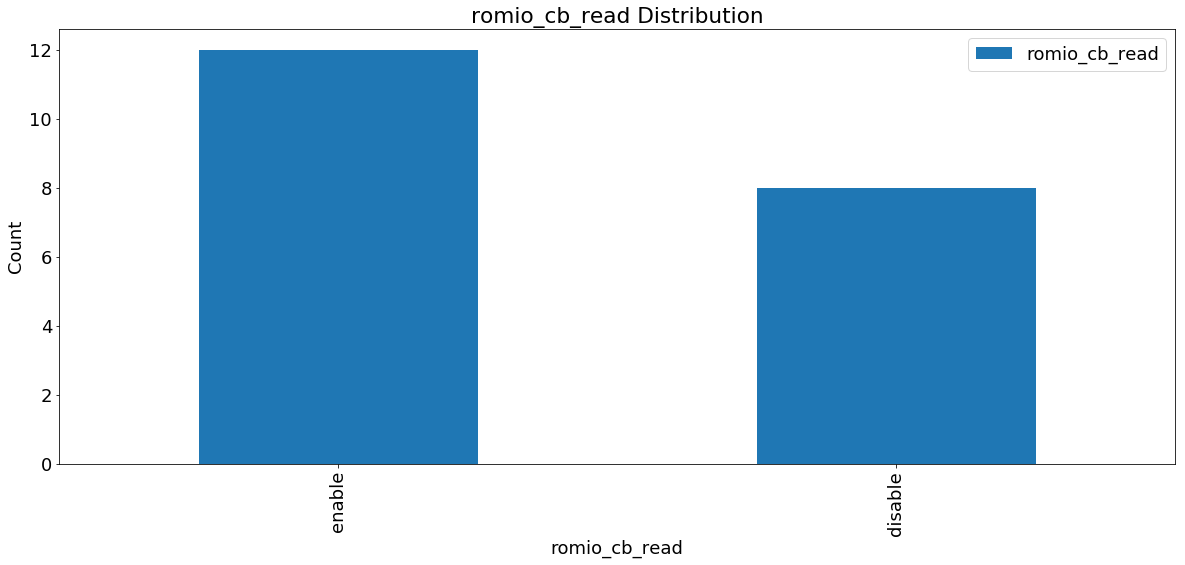

In [20]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

bayes_params['romio_cb_read'].value_counts().plot.bar()#plt.hist(romio_cb_read_dist,color="red",linewidth=2, label = 'initial romio_cb_read')

plt.legend()
plt.xlabel('romio_cb_read'); plt.ylabel('Count'); plt.title('romio_cb_read Distribution');
plt.savefig(file_suffix+'_romio_cb_read.png')

In [21]:
os.chdir('../')